In [19]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pydicom

import gc
import warnings

warnings.simplefilter(action = 'ignore')
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.metrics import roc_auc_score, mean_absolute_error
from sklearn.model_selection import KFold

In [21]:
detailed_class_info = pd.read_csv('../data/stage_1_detailed_class_info.csv')
train_labels = pd.read_csv('../data/stage_1_train_labels.csv')

df = pd.merge(left = detailed_class_info, right = train_labels, how = 'left', on = 'patientId')

del detailed_class_info, train_labels
gc.collect()

df.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35875 entries, 0 to 35874
Data columns (total 7 columns):
patientId    35875 non-null object
class        35875 non-null object
x            15850 non-null float64
y            15850 non-null float64
width        15850 non-null float64
height       15850 non-null float64
Target       35875 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 2.2+ MB


In [22]:
df.head()

,patientId,class,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1


In [23]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28989 entries, 0 to 35874
Data columns (total 7 columns):
patientId    28989 non-null object
class        28989 non-null object
x            8964 non-null float64
y            8964 non-null float64
width        8964 non-null float64
height       8964 non-null float64
Target       28989 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


In [24]:
df['patientId'].value_counts().head(10)

0ab261f9-4eb5-42ab-a9a5-e918904d6356    4
349f10b4-dc3e-4f3f-b2e4-a5b81448ce87    4
1bf08f3b-a273-4f51-bafa-b55ada2c23b5    4
31764d54-ea3b-434f-bae2-8c579ed13799    4
8dc8e54b-5b05-4dac-80b9-fa48878621e2    4
76f71a93-8105-4c79-a010-0cfa86f0061a    4
ee820aa5-4804-4984-97b3-f0a71d69702f    4
0d5bc737-03de-4bb8-98a1-45b7180c3e0f    4
32408669-c137-4e8d-bd62-fe8345b40e73    4
3239951b-6211-4290-b237-3d9ad17176db    4
Name: patientId, dtype: int64

In [25]:
df[df['patientId'] == '32408669-c137-4e8d-bd62-fe8345b40e73']

,patientId,class,x,y,width,height,Target
3433,32408669-c137-4e8d-bd62-fe8345b40e73,Lung Opacity,273.0,856.0,234.0,101.0,1
3434,32408669-c137-4e8d-bd62-fe8345b40e73,Lung Opacity,702.0,801.0,249.0,144.0,1
3435,32408669-c137-4e8d-bd62-fe8345b40e73,Lung Opacity,300.0,367.0,226.0,423.0,1
3436,32408669-c137-4e8d-bd62-fe8345b40e73,Lung Opacity,706.0,360.0,232.0,238.0,1


In [26]:
df['patientId'].value_counts().value_counts()

1    22506
2     3062
3      105
4       11
Name: patientId, dtype: int64

In [27]:
df[df['Target'] == 0]['patientId'].value_counts().value_counts()

1    20025
Name: patientId, dtype: int64

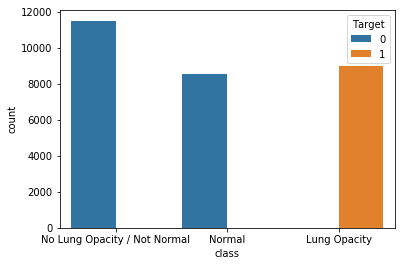

In [28]:
sns.countplot(x = 'class', hue = 'Target', data = df);

In [29]:
df[df['class'] == 'Lung Opacity']['Target'].value_counts(dropna = False)

1    8964
Name: Target, dtype: int64

In [30]:

df[df['class'] == 'No Lung Opacity / Not Normal']['Target'].value_counts(dropna = False)

0    11500
Name: Target, dtype: int64

In [31]:
df[df['class'] == 'Normal']['Target'].value_counts(dropna = False)

0    8525
Name: Target, dtype: int64

In [32]:
print('Patients can have {} different classes'.format(df.groupby('patientId')['class'].nunique().nunique()))

Patients can have 1 different classes


In [33]:
df_areas = df.dropna()[['x', 'y', 'width', 'height']].copy()
df_areas['x_2'] = df_areas['x'] + df_areas['width']
df_areas['y_2'] = df_areas['y'] + df_areas['height']
df_areas['x_center'] = df_areas['x'] + df_areas['width'] / 2
df_areas['y_center'] = df_areas['y'] + df_areas['height'] / 2
df_areas['area'] = df_areas['width'] * df_areas['height']

df_areas.head()

,x,y,width,height,x_2,y_2,x_center,y_center,area
4,264.0,152.0,213.0,379.0,477.0,531.0,370.5,341.5,80727.0
5,562.0,152.0,256.0,453.0,818.0,605.0,690.0,378.5,115968.0
10,323.0,577.0,160.0,104.0,483.0,681.0,403.0,629.0,16640.0
11,695.0,575.0,162.0,137.0,857.0,712.0,776.0,643.5,22194.0
18,288.0,322.0,94.0,135.0,382.0,457.0,335.0,389.5,12690.0


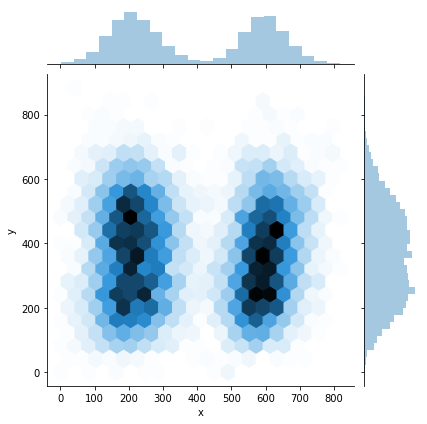

In [34]:
sns.jointplot(x = 'x', y = 'y', data = df_areas, kind = 'hex', gridsize = 20);

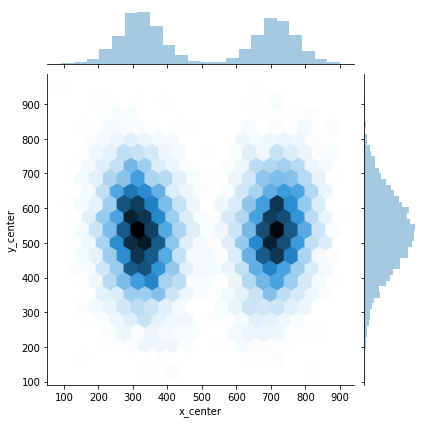

In [35]:
sns.jointplot(x = 'x_center', y = 'y_center', data = df_areas, kind = 'hex', gridsize = 20);

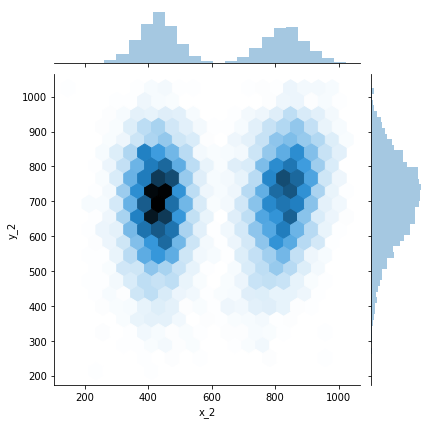

In [36]:
sns.jointplot(x = 'x_2', y = 'y_2', data = df_areas, kind = 'hex', gridsize = 20);

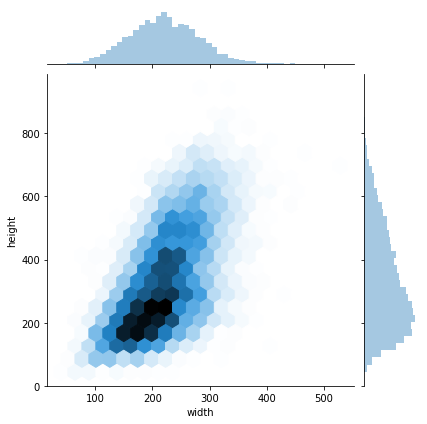

In [38]:
sns.jointplot(x = 'width', y = 'height', data = df_areas, kind = 'hex', gridsize = 20);

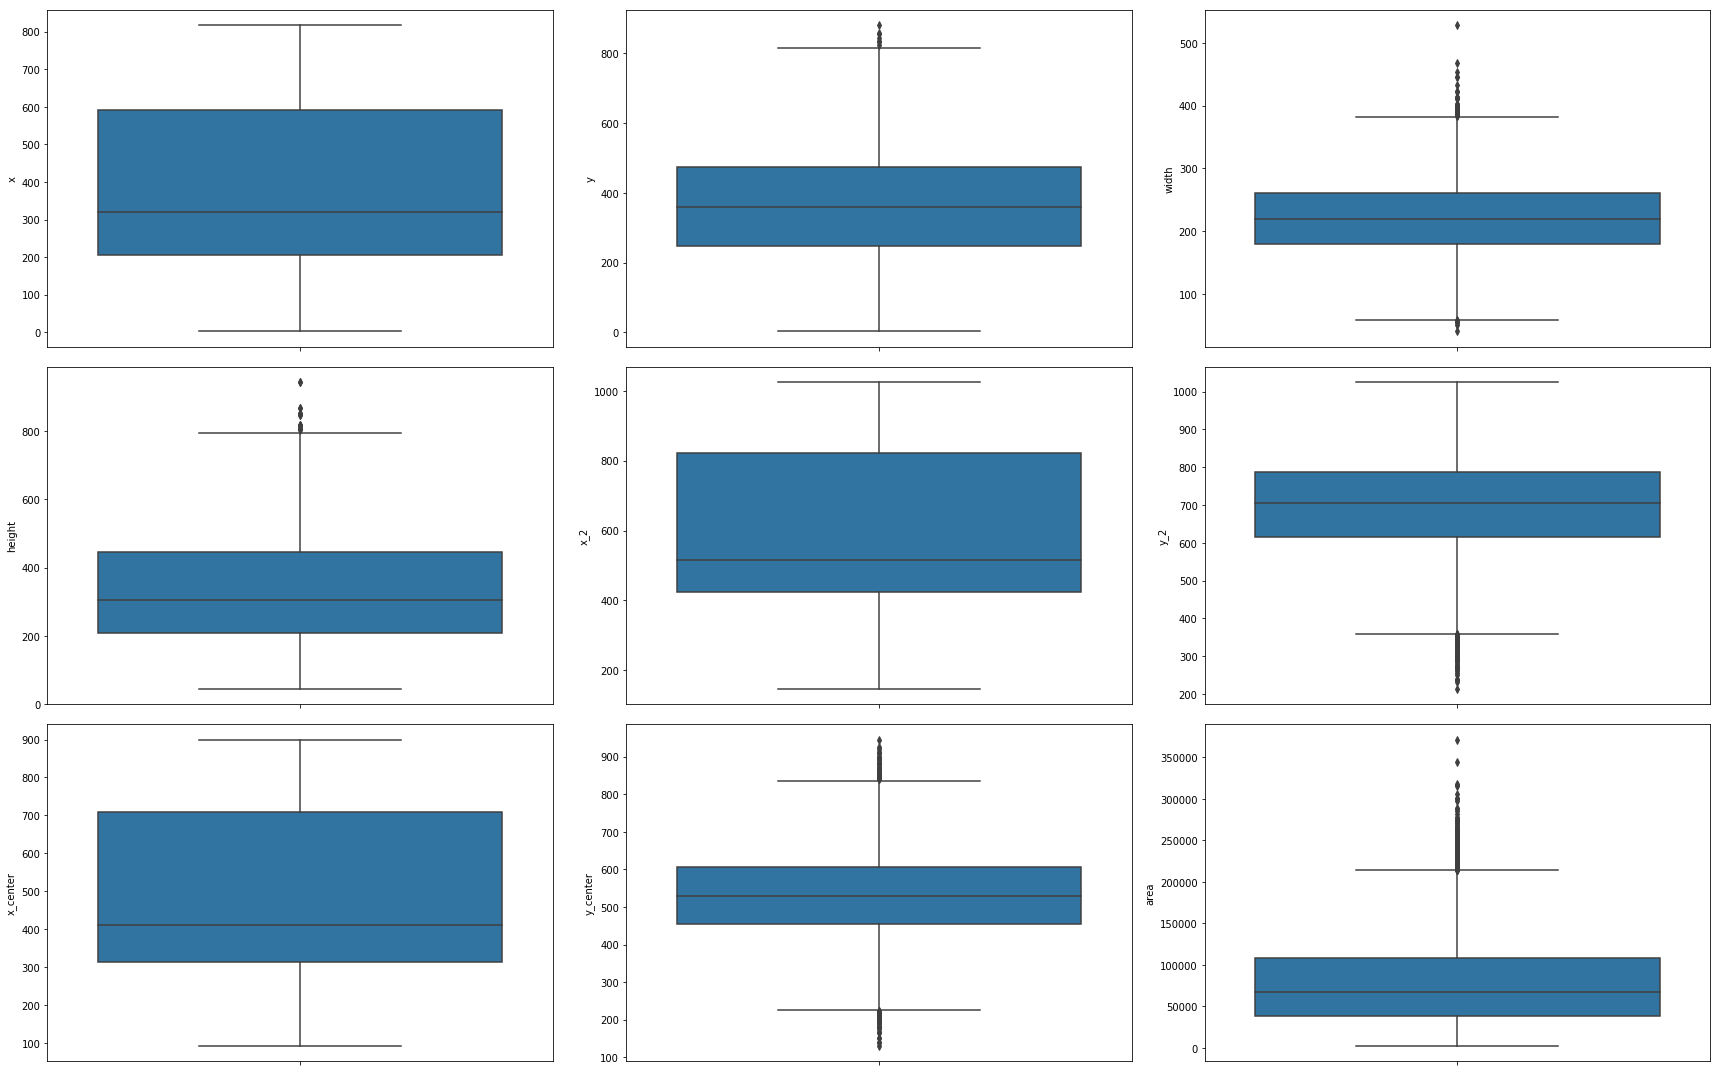

In [37]:
n_columns = 3
n_rows = 3
_, axes = plt.subplots(n_rows, n_columns, figsize=(8 * n_columns, 5 * n_rows))
for i, c in enumerate(df_areas.columns):
    sns.boxplot(y = c, data = df_areas, ax = axes[i // n_columns, i % n_columns])
plt.tight_layout()
plt.show()